### Import Library

In [44]:
import pandas as pd
from urllib.parse import unquote
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import re
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns
import pickle
import xgboost

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [2]:
# Configure
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

### Import Data

In [4]:
# Attack Data Sql
df_at = pd.read_csv('attack_sql2.txt', delimiter = "\t", header=None)
df_at.columns = ['Log']
df_at['Label'] =  1

df_no = pd.read_csv('safe_sql.txt', delimiter = "\t", header=None)
df_no.columns = ['Log']
df_no['Label'] = 0

In [14]:
df = df_at.append(df_no, ignore_index=True, sort=False)

In [8]:
df.head()

,Log,Label
0,"36.72.215.113 - - [23/Apr/2021:02:30:47 +0000] ""GET /mod.php?kategori=lounge&id=4%20order%20by%2...",1
1,"36.72.215.113 - - [23/Apr/2021:02:30:52 +0000] ""GET /mod.php?kategori=lounge&id=4%20order%20by%2...",1
2,"36.72.215.113 - - [23/Apr/2021:02:30:58 +0000] ""GET /mod.php?kategori=lounge&id=4%20order%20by%2...",1
3,"36.72.215.113 - - [23/Apr/2021:02:31:06 +0000] ""GET /mod.php?kategori=lounge&id=4%20order%20by%2...",1
4,"36.72.215.113 - - [23/Apr/2021:02:31:09 +0000] ""GET /mod.php?kategori=lounge&id=4%20order%20by%2...",1


<AxesSubplot:title={'center':'Count (target)'}>

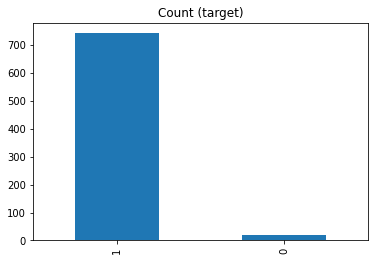

In [10]:
df.Label.value_counts().plot(kind='bar', title='Count (target)')

### Preprocessing

In [6]:
def preprocessing(df):
    df['Ip'] = df['Log'].str.split(' - - ').str[0]

    df['Time'] = df['Log'].str.split('] ').str[0]
    df['Time'] = df['Time'].str.split(' - - ').str[1]+']'

    df['Log2'] = df['Log'].str.split('] ').str[1]


    df['Request'] = df['Log2'].str.split('"').str[1]
    df['Request'] = df['Request'].apply(lambda x : re.sub(r'^.*?php?', '', x))

    df['Angka'] = df['Log2'].str.split('"').str[2]

    df['Kembalian'] = df['Log2'].str.split('"').str[3]

    df['User_Header'] = df['Log2'].str.split('"').str[-2]

    df.drop(['Log','Log2','Angka','Kembalian','User_Header'], axis=1, inplace=True)
    
    return df

def preprocess(a):
    a = a.lower().replace('(',' ').replace(')',' ').strip()
    a = ' '.join(a.split())
    a = a.split()
    return a

def count_string2(data, list_words):
    total = 0
    for word in list_words:
        counter = data.count(word)
        total += counter
    return total

def check_always_true(data):
    return bool(re.findall(r"\d=\d",data))

def feature_engineering(df):
    df['Request1'] = df['Request'].str.replace('GET /', '')
    df['Request1'] = df['Request1'].str.replace('POST /', '')
    df['Request1'] = df['Request1'].str.replace('HTTP/1.1', '')
    df['Request1'] = df['Request1'].str.lower()
    df['Request2'] = df['Request1'].apply(lambda x : unquote(x))

    df['Comment_Count'] = df['Request2'].apply(lambda x : count_string2(x, ['--','/**/']))
    df['Operator_Count'] = df['Request2'].apply(lambda x : count_string2(x, ['<','>','<=','>=', '==', '!=','&&', '||' '<<', '>>', '|', '&', '+', '%', '^']))
    df['SqlKeyword_Count'] = df['Request2'].apply(lambda x : count_string2(x, ['select', 'update', 'insert', 'create', 'drop', 'alter', 'rename', 'group', 'union', 'having', 
                                                                            'concat', 'order','values', 'declare', 'substring', 'table']))
    df.loc[df['SqlKeyword_Count']>=1, 'Any_SQL_Keyword'] = 1
    df.loc[df['SqlKeyword_Count']<1, 'Any_SQL_Keyword'] = 0
    df['Any_SQL_Keyword'] = df['Any_SQL_Keyword'].astype(bool)

    df['Semicolon_Count'] = df['Request2'].apply(lambda x : count_string2(x, ';'))

    df['Any_Always_True'] = df['Request2'].apply(lambda x: check_always_true(x))

    df = df[[ 'Label', 'Ip', 'Time','Request2',
           'Comment_Count', 'Operator_Count',
           'SqlKeyword_Count', 'Any_Always_True','Any_SQL_Keyword','Semicolon_Count']]
    
    return df

def clean_text(text):
    text_rc = re.sub('[0-9]+', '', text)
    tokens = re.split('\W+', text_rc)    # tokenization
    return tokens

def term_frequency(df):
    vectorizer = CountVectorizer(analyzer=clean_text, decode_error="replace",vocabulary=pickle.load(open("vocab.pkl", "rb")))
    tfidf = vectorizer.fit_transform(df['Request2'])

    vect_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
    vect_df = vect_df[['select', 'union', 'concat', 'null', 'like', 'or','exec','and','having','char', 'order']]
    df_tf = pd.concat([df.reset_index(drop=True), vect_df.reset_index(drop=True)], axis=1)
    pickle.dump(vectorizer.vocabulary_,open("vocab.pkl","wb"))

    return df_tf

def pipeline(df):
    test_bersih = preprocessing(df)
    test_fe = feature_engineering(test_bersih)
    test_tf = term_frequency(test_fe)
    
    return test_tf

#### Split Data

In [15]:
df_split = preprocessing(df)

In [16]:
df_split.head()

,Label,Ip,Time,Request
0,1,36.72.215.113,[23/Apr/2021:02:30:47 +0000],?kategori=lounge&id=4%20order%20by%2010--%20- HTTP/1.1
1,1,36.72.215.113,[23/Apr/2021:02:30:52 +0000],?kategori=lounge&id=4%20order%20by%20106--%20- HTTP/1.1
2,1,36.72.215.113,[23/Apr/2021:02:30:58 +0000],?kategori=lounge&id=4%20order%20by%20101--%20- HTTP/1.1
3,1,36.72.215.113,[23/Apr/2021:02:31:06 +0000],?kategori=lounge&id=4%20order%20by%201--%20- HTTP/1.1
4,1,36.72.215.113,[23/Apr/2021:02:31:09 +0000],?kategori=lounge&id=4%20order%20by%202--%20- HTTP/1.1


#### Feature Engineering

In [17]:
df_fe = feature_engineering(df_split)

In [18]:
df_fe.head()

,Label,Ip,Time,Request2,Comment_Count,Operator_Count,SqlKeyword_Count,Any_Always_True,Any_SQL_Keyword,Semicolon_Count
0,1,36.72.215.113,[23/Apr/2021:02:30:47 +0000],?kategori=lounge&id=4 order by 10-- -,1,1,1,False,True,0
1,1,36.72.215.113,[23/Apr/2021:02:30:52 +0000],?kategori=lounge&id=4 order by 106-- -,1,1,1,False,True,0
2,1,36.72.215.113,[23/Apr/2021:02:30:58 +0000],?kategori=lounge&id=4 order by 101-- -,1,1,1,False,True,0
3,1,36.72.215.113,[23/Apr/2021:02:31:06 +0000],?kategori=lounge&id=4 order by 1-- -,1,1,1,False,True,0
4,1,36.72.215.113,[23/Apr/2021:02:31:09 +0000],?kategori=lounge&id=4 order by 2-- -,1,1,1,False,True,0


#### Term Frequency & TF-Idf

In [19]:
df_tf = term_frequency(df_fe)

In [21]:
df_tf.tail()

,Label,Ip,Time,Request2,Comment_Count,Operator_Count,SqlKeyword_Count,Any_Always_True,Any_SQL_Keyword,Semicolon_Count,select,union,concat,null,like,or,exec,and,having,char,order
758,0,103.142.110.26,[23/Apr/2021:01:51:15 +0000],images/right-bg.png,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0
759,0,103.142.110.26,[23/Apr/2021:01:51:15 +0000],images/line_right.png,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0
760,0,103.142.110.26,[23/Apr/2021:01:51:15 +0000],images/line.png,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0
761,0,103.142.110.26,[23/Apr/2021:01:51:15 +0000],images/footer-bg.png,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0
762,0,103.142.110.26,[23/Apr/2021:01:51:16 +0000],favicon.ico,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0


### Oversampling

In [22]:
test = df_tf.copy()
X_tf = test.drop(['Label',], axis=1)
y_tf = test['Label']
X_tf = X_tf.iloc[:,3:]

smote = SMOTE(sampling_strategy='minority')
X_sm_tf, y_sm_tf = smote.fit_sample(X_tf, y_tf)

df_sm_tf = pd.concat([X_sm_tf, y_sm_tf.reindex(X_sm_tf.index)], axis=1)

# Move Label to 1st
first_column = df_sm_tf.pop('Label')
df_sm_tf.insert(0, 'Label', first_column)

In [26]:
df_sm_tf.head()

,Label,Comment_Count,Operator_Count,SqlKeyword_Count,Any_Always_True,Any_SQL_Keyword,Semicolon_Count,select,union,concat,null,like,or,exec,and,having,char,order
0,1,1,1,1,False,True,0,0,0,0,0,0,0,0,0,0,0,1
1,1,1,1,1,False,True,0,0,0,0,0,0,0,0,0,0,0,1
2,1,1,1,1,False,True,0,0,0,0,0,0,0,0,0,0,0,1
3,1,1,1,1,False,True,0,0,0,0,0,0,0,0,0,0,0,1
4,1,1,1,1,False,True,0,0,0,0,0,0,0,0,0,0,0,1


<AxesSubplot:title={'center':'Count (target)'}>

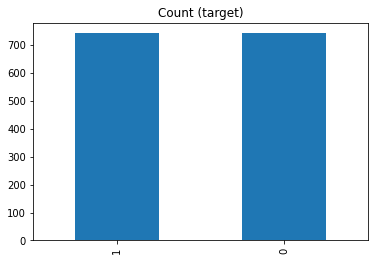

In [25]:
df_sm_tf.Label.value_counts().plot(kind='bar', title='Count (target)')

### Modelling TF

In [27]:
df_sm_tf.corr()

,Label,Comment_Count,Operator_Count,SqlKeyword_Count,Any_Always_True,Any_SQL_Keyword,Semicolon_Count,select,union,concat,null,like,or,exec,and,having,char,order
Label,1.000000,0.715017,0.329358,0.752471,0.322749,0.887666,0.162109,0.691870,0.632688,0.580138,0.411924,0.036736,0.110808,0.036736,0.336713,0.036736,0.086931,0.141178
Comment_Count,0.715017,1.000000,0.102110,0.735280,-0.153422,0.759962,0.134574,0.420221,0.832815,0.680801,0.530437,0.050769,-0.079229,0.127804,-0.172624,-0.026267,-0.027977,0.195107
Operator_Count,0.329358,0.102110,1.000000,0.156111,0.449832,0.302674,0.085143,0.324415,0.021439,0.003695,0.002521,0.000074,0.004302,0.073112,0.505703,0.000074,0.281034,0.000284
SqlKeyword_Count,0.752471,0.735280,0.156111,1.000000,0.180494,0.847695,-0.024664,0.817733,0.859873,0.856422,0.516826,0.035210,0.197485,0.056161,-0.007433,0.056161,0.030644,-0.025717
Any_Always_True,0.322749,-0.153422,0.449832,0.180494,1.000000,0.205714,-0.023131,0.432460,-0.117038,0.015877,-0.130763,-0.011856,0.343325,0.113822,0.608763,0.113822,0.250758,-0.045565
Any_SQL_Keyword,0.887666,0.759962,0.302674,0.847695,0.205714,1.000000,0.113882,0.779425,0.712755,0.653554,0.464052,0.041385,0.124830,0.041385,0.177050,0.041385,0.097932,0.159044
Semicolon_Count,0.162109,0.134574,0.085143,-0.024664,-0.023131,0.113882,1.000000,0.084310,-0.084643,-0.094046,-0.062734,-0.005955,-0.017963,0.226612,-0.035885,-0.005955,-0.014092,-0.022886
select,0.691870,0.420221,0.324415,0.817733,0.432460,0.779425,0.084310,1.000000,0.570718,0.479790,0.272966,0.024343,0.306905,0.024343,0.251132,0.024343,0.167997,-0.097677
union,0.632688,0.832815,0.021439,0.859873,-0.117038,0.712755,-0.084643,0.570718,1.000000,0.748187,0.564370,0.053920,0.007476,0.053920,-0.188218,-0.023242,-0.055000,-0.089322
concat,0.580138,0.680801,0.003695,0.856422,0.015877,0.653554,-0.094046,0.479790,0.748187,1.000000,0.571292,0.024926,0.075186,-0.021312,-0.135858,0.024926,-0.050432,-0.081903


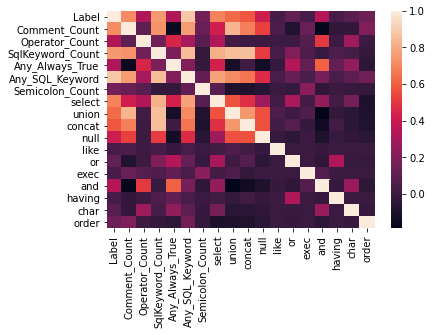

In [28]:
sns.heatmap(df_sm_tf.corr());

### ML Model

In [29]:
classifiers = []

model1 = xgboost.XGBClassifier()
classifiers.append(model1)
model2 = svm.SVC()
classifiers.append(model2)
model3 = tree.DecisionTreeClassifier()
classifiers.append(model3)
model4 = RandomForestClassifier()
classifiers.append(model4)

#### Split Train, Validation, Test Data

In [37]:
X = df_sm_tf.drop(['Label'], axis=1)
y = df_sm_tf['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [38]:
X_train.shape, X_val.shape, X_test.shape

((949, 17), (238, 17), (297, 17))

In [79]:
df_sm_tf.to_csv('data_train_tf.csv')

#### Find best ML Predictor

In [39]:
classifiers = []

model1 = xgboost.XGBClassifier()
classifiers.append(model1)
model2 = svm.SVC()
classifiers.append(model2)
model3 = tree.DecisionTreeClassifier()
classifiers.append(model3)
model4 = RandomForestClassifier()
classifiers.append(model4)

In [43]:
# Evalueagte using Validation data
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred1 = clf.predict(X_val)
    y_pred2 = clf.predict(X_test)
    acc1 = accuracy_score(y_val, y_pred1)
    acc2 = accuracy_score(y_test, y_pred2)
    print("Accuracy using Validation data of %s is %s"%(clf, acc1))
    print("Accuracy using Test data of %s is %s"%(clf, acc2))
    
    cm = confusion_matrix(y_val, y_pred)
    # print("Confusion Matrix of %s is %s"%(clf, cm))

Accuracy using Validation data of XGBClassifier() is 0.9915966386554622
Accuracy using Test data of XGBClassifier() is 1.0
Accuracy using Validation data of SVC() is 0.9915966386554622
Accuracy using Test data of SVC() is 1.0
Accuracy using Validation data of DecisionTreeClassifier() is 0.9915966386554622
Accuracy using Test data of DecisionTreeClassifier() is 1.0
Accuracy using Validation data of RandomForestClassifier() is 0.9915966386554622
Accuracy using Test data of RandomForestClassifier() is 1.0


#### Using Decision Tree with Cross Validation

In [45]:
X = df_sm_tf.drop(['Label'], axis=1)
y = df_sm_tf['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [50]:
clf = tree.DecisionTreeClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
mod = clf.fit(X_train, y_train)
y_pred = mod.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy of %s is %s"%(clf, acc))
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

[1.         0.99579832 0.99578059 1.         0.99156118]
Accuracy of DecisionTreeClassifier() is 1.0
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00       147
     class 1       1.00      1.00      1.00       150

    accuracy                           1.00       297
   macro avg       1.00      1.00      1.00       297
weighted avg       1.00      1.00      1.00       297



#### Save Model

In [51]:
# save the model to disk
filename = 'finalized_model_sqli.pkl'
pickle.dump(mod, open(filename, 'wb'))

### Test With New Data

#### Load Model

In [52]:
filename = 'finalized_model_sqli.pkl'
loaded_model = pickle.load(open(filename, 'rb'))

#### Test Data

In [68]:
data = """ 36.72.215.113 - - [23/Apr/2021:02:34:54 +0000] "GET /mod.php?kategori=lounge&id=6950 HTTP/1.1" 200 2349 "-" "sqlmap/1.5.2#stable (http://sqlmap.org)" """

In [72]:
data1 = {'Log':  [data],
        'Label': 1}

df1 = pd.DataFrame (data1, columns = ['Log','Label'])

In [73]:
df1

,Log,Label
0,"36.72.215.113 - - [23/Apr/2021:02:34:54 +0000] ""GET /mod.php?kategori=lounge&id=6950 HTTP/1.1"" ...",1


In [74]:
# Pipeline to preprocess, split, and feature engineering
test_tf = pipeline(df1)

In [75]:
test_tf

,Label,Ip,Time,Request2,Comment_Count,Operator_Count,SqlKeyword_Count,Any_Always_True,Any_SQL_Keyword,Semicolon_Count,select,union,concat,null,like,or,exec,and,having,char,order
0,1,36.72.215.113,[23/Apr/2021:02:34:54 +0000],?kategori=lounge&id=6950,0,1,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0


In [76]:
test_tf = test_tf.iloc[:,4:]

In [77]:
test_tf

,Comment_Count,Operator_Count,SqlKeyword_Count,Any_Always_True,Any_SQL_Keyword,Semicolon_Count,select,union,concat,null,like,or,exec,and,having,char,order
0,0,1,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
loaded_model.predict(test_tf)

array([1], dtype=int64)